# Анализ гипотез по увеличению выручки интернет-магазина

## Описание проекта

Вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки интернет-магазина.
Необходимо приоритезировать гипотезы, запустить A/B-тест и проанализировать результаты.

Основной вопрос, на который должно ответить исследование в проекте - это приоритезировать
гипотезы по увеличению выручки интернет-магазина, проанализировать результаты A/B теста, направленного на определение
версии сайта, который даст наибольшую выручку.

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt

import warnings
warnings.simplefilter('ignore')

## Часть 1. Приоритизация гипотез

In [2]:
# Загрузка файла hypothesis.csv, оптимизация названий столбцов
hypo = pd.read_csv('/datasets/hypothesis.csv')
hypo.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']
hypo

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [3]:
hypo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
hypothesis    9 non-null object
reach         9 non-null int64
impact        9 non-null int64
confidence    9 non-null int64
efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Описание данных:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [4]:
# Посчитаем параметр ICE для каждой гипотезы
hypo['ICE'] = (hypo['impact'] * hypo['confidence']) / hypo['efforts']

In [5]:
# Отсортируем гипотезы по убыванию параметра ICE
hypo.sort_values(by = 'ICE', ascending = False)[['hypothesis', 'ICE']]

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.200000
0,"Добавить два новых канала привлечения трафика,...",13.333333
7,Добавить форму подписки на все основные страни...,11.200000
6,Показать на главной странице баннеры с актуаль...,8.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
1,"Запустить собственную службу доставки, что сок...",2.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000


In [6]:
# Посчитаем параметр RICE для каждой гипотезы
hypo['RICE'] = hypo['reach'] * hypo['impact'] * hypo['confidence'] / hypo['efforts']

In [7]:
# Отсортируем гипотезы по убыванию параметра RICE
hypo.sort_values(by = 'RICE', ascending = False)[['hypothesis', 'RICE']]

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


После применения <b>RICE</b> вместо ICE на первые места вышли две гипотезы:
- 7 "Добавить форму подписки на все основные страницы"
- 2 "Добавить блоки рекомендаций товаров на сайт интернет-магазина"

Это произошло потому что в этом фреймворке был добавлен показатель охват (reach) - скольких пользователей затронет данное изменение, и этот параметр был выше у данных гипотез, а также у гипотезы 3 - "Изменить структуру категорий, что увеличит конверсию". У этой гипотезы, однако, достаточно высокий показатель стоимости проверки гипотезы (efforts), что видимо связано с серьезной переработкой сайта магазина, что не позволило этой гипотезе занять высокое место.

## Часть 2. Анализ A/B-теста

### Загрузка исходных данных

In [8]:
# Загрузим данные из файла orders.csv оптимизируем названия столбцов и типы данных
orders = pd.read_csv('/datasets/orders.csv')
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Описание данных:

- transaction_id — идентификатор заказа;
- visitor_id — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

In [10]:
# Загрузим данные из файла visitors.csv и оптимизируем типы данных
visitors = pd.read_csv('/datasets/visitors.csv')
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


In [11]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Описание данных:

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Выводы по загруженным данным:

Были загружены 2 датасета:
- orders.csv - данные о заказах (1197 записей, 5 столбцов)
- visitors.csv - данные о количестве пользователей групп А/B теста в определенную дату (62 записи, 3 столбца)

В процессе загрузки в обоих датасетах столбец с датами был приведен к формату datetime, в остальных столбцах формат данных корректен.

Пропусков и дубликатов в обоих датасетах не обнаружено.</span>

### 2.1. Построение графика куммулятивной выручки по группам

In [12]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [13]:
# Создадим массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates()
dates_groups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [14]:
# Посчитаем агрегированные кумулятивные по дням данные о заказах
orders_aggregated = dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                                      orders['group'] == x['group'])]
                               .agg({'date' : 'max',
                                     'group' : 'max',
                                     'transaction_id' : 'nunique',
                                     'visitor_id' : 'nunique',
                                     'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])
orders_aggregated

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


In [15]:
# Посчитаем агрегированные кумулятивные по дням данные о посетителях
visitors_aggregated = dates_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                           visitors['group'] == x['group'])]
                                         .agg({'date' : 'max', 
                                               'group' : 'max', 
                                               'visitors' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])
visitors_aggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [16]:
# Объединим кумулятивные данные по заказам и посетителям в одну таблицу
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on = ['date', 'group'], right_on = ['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845
...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708
58,2019-08-30,A,545,493,4022970,18037
59,2019-08-30,B,620,567,5774631,18198
60,2019-08-31,A,557,503,4084803,18736


In [17]:
# Кумулятивная выручка и количество заказов группы А
cumulative_revenue_A = cumulative_data[cumulative_data['group'] == 'A'][['date','revenue', 'orders']]
cumulative_revenue_A.head(3)

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68


In [18]:
# Кумулятивная выручка и количество заказов группы B
cumulative_revenue_B = cumulative_data[cumulative_data['group'] == 'B'][['date','revenue', 'orders']]
cumulative_revenue_B.head(3)

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


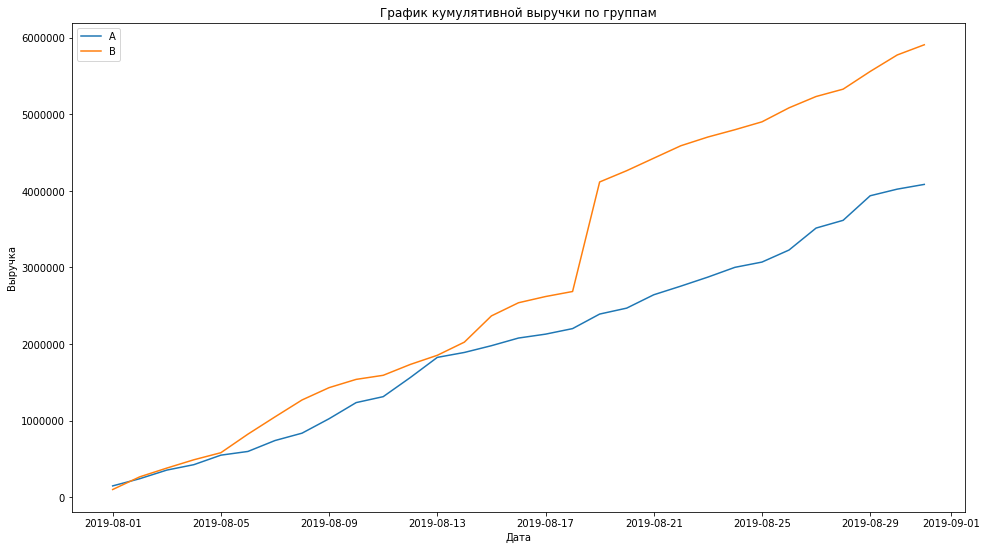

In [19]:
# Построим график кумулятивной выручки по группам
plt.figure(figsize = (16, 9))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label = 'A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label = 'B')
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

Выручка почти равномерно увеличивается в течение всего теста - это хорошо.

В выручке группы B есть резкий всплеск, что может свидетельствовать о появлении очень дорогих заказов в выборке.

### 2.2. Построение графика кумулятивного среднего чека по группам

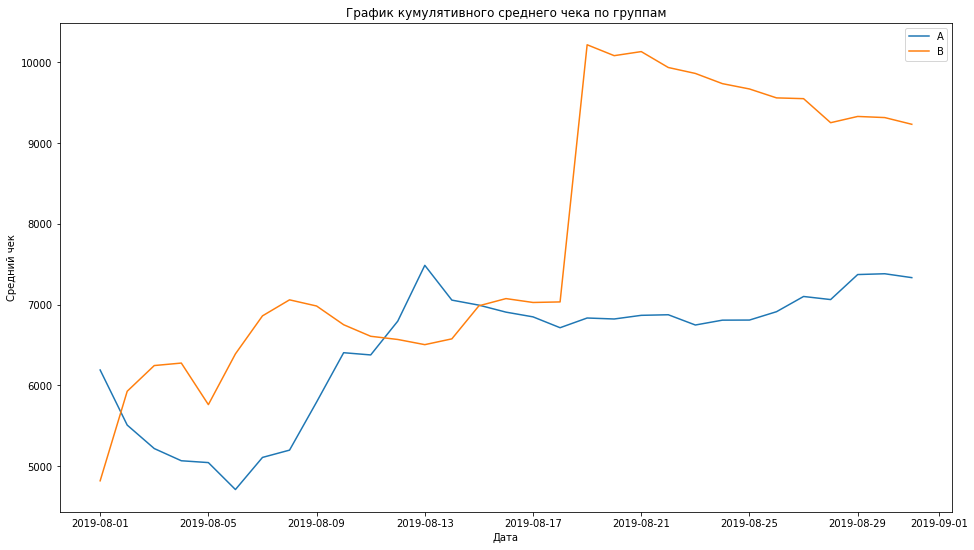

In [20]:
plt.figure(figsize = (16, 9))
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'] / cumulative_revenue_A['orders'], label = 'A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'] / cumulative_revenue_B['orders'], label = 'B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

К концу теста средний чек становится равномерным в обоих группах. Устанавливается примерно на одном уровне для группы А и после резкого всплеска продолжает падать для группы B - для него необходимо еще время для устойчивости.

### 2.3. Построение графика относительного изменения кумулятивного среднего чека группы B к группе A

In [21]:
# Соберем данные в одну таблицу
merged_сumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, 
                                                       left_on='date', 
                                                       right_on='date', 
                                                       how='left', 
                                                       suffixes=['_A', '_B'])
merged_сumulative_revenue.head()

,date,revenue_A,orders_A,revenue_B,orders_B
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


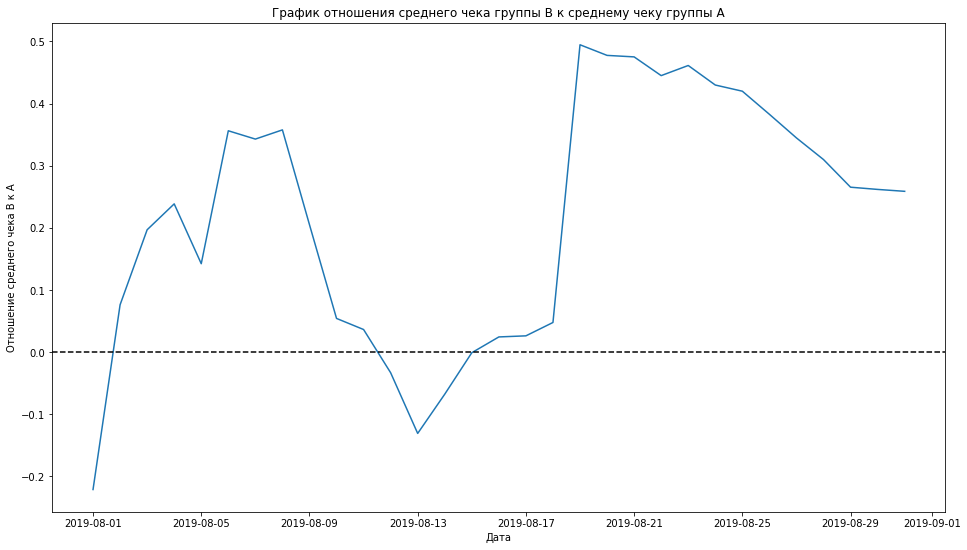

In [22]:
# Поcтроим график отношения средних чеков и добавим горизонтальную нулевую линию
plt.figure(figsize = (16, 9))
plt.plot(merged_сumulative_revenue['date'], 
         (merged_сumulative_revenue['revenue_B']/merged_сumulative_revenue['orders_B'])\
         /(merged_сumulative_revenue['revenue_A']/merged_сumulative_revenue['orders_A']) - 1)
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.title('График отношения среднего чека группы B к среднему чеку группы A')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека B к А')
plt.show()

В нескольких точках на графике видны резкие колебания. Возможно это происходит из-за "выбросов" в виде крупных заказов.

### 2.4. Построение графика кумулятивной конверсии по группам

In [23]:
# Посчитаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_data

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856
...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708,0.033657
58,2019-08-30,A,545,493,4022970,18037,0.030216
59,2019-08-30,B,620,567,5774631,18198,0.034070
60,2019-08-31,A,557,503,4084803,18736,0.029729


In [24]:
# Поделим данные на группы
cumulative_data_A = cumulative_data[cumulative_data['group'] == 'A']
cumulative_data_B = cumulative_data[cumulative_data['group'] == 'B']

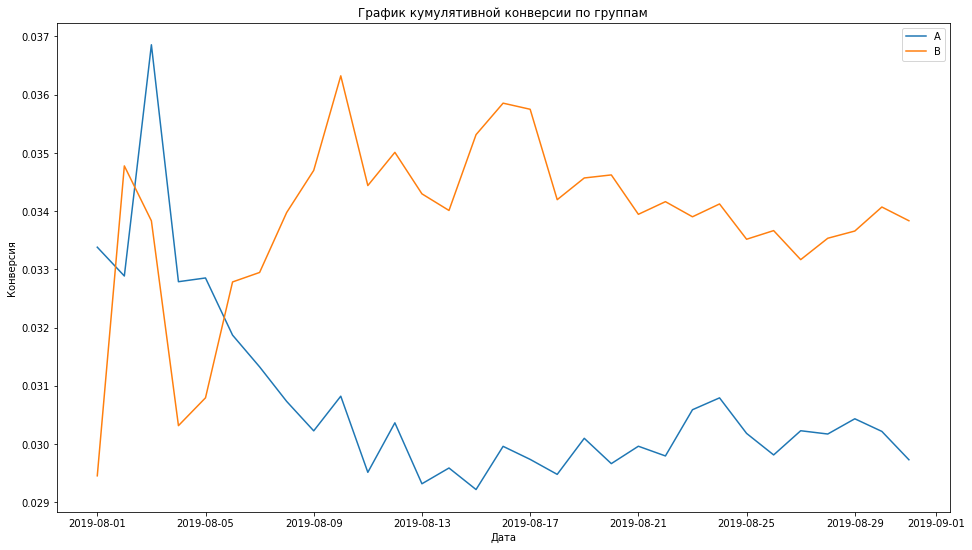

In [25]:
# Построим графики
plt.figure(figsize = (16, 9))
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label = 'A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label = 'B')
plt.legend()
#plt.axis([pd.to_datetime('2019-08-01'), pd.to_datetime('2019-08-31'), 0.029, 0.037])
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

По графику видно конверсия группы B установилась выше чем конверсия группы A, хотя изначально все было наоборот.

В начале теста были резкие колебания конверсий, к концу теста установились 
более стабильные значения.

### 2.5. Построение графика относительного изменения кумулятивной конверсии группы B к группе A

In [26]:
# Соберем данные по кумулятивным конверсиям групп в одну таблицу
merged_cumulative_conversions = cumulative_data_A[['date','conversion']]\
.merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])
merged_cumulative_conversions.head()

,date,conversion_A,conversion_B
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


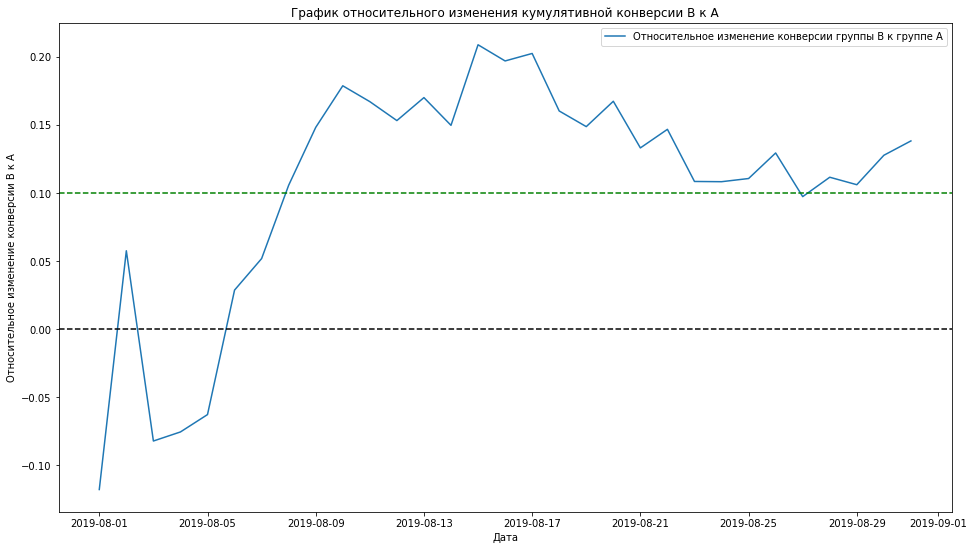

In [27]:
# Построим график
plt.figure(figsize = (16, 9))
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversion_B'] / merged_cumulative_conversions['conversion_A'] - 1, 
         label = "Относительное изменение конверсии группы B к группе A")
plt.legend()
plt.axhline(y = 0, color = 'black', linestyle = '--')
plt.axhline(y = 0.1, color = 'green', linestyle = '--')
plt.title('График относительного изменения кумулятивной конверсии B к А')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение конверсии В к А')
plt.show()

Вначале конверсия группы B резко выросла, затем установилась около значения 0.1 и опять начала расти.

В целом отношение конверсии ещё не установилось, и делать какие-либо выводы по тесту пока нельзя, сначала стоит проанализировать аномалии, возможно, они изменят картину.

### 2.6. Построение точечного графика количества заказов по пользователям

In [28]:
# Посчитаем кол-во заказов на одного клиента
orders_by_visitors = orders.drop(['group', 'revenue', 'date'], axis = 1).groupby('visitor_id', as_index = False)\
.agg({'transaction_id' : 'nunique'})
orders_by_visitors.columns = ['visitor_id','orders']
orders_by_visitors.sort_values(by = 'orders', ascending=False).head(10)

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


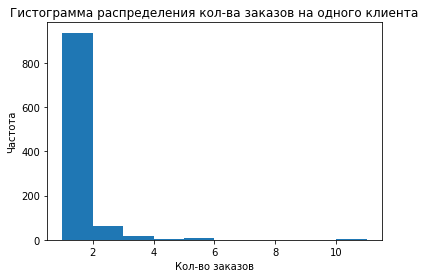

In [29]:
# Построим гистограмму их распределения
plt.hist(orders_by_visitors['orders'])
plt.title('Гистограмма распределения кол-ва заказов на одного клиента')
plt.xlabel('Кол-во заказов')
plt.ylabel('Частота')
plt.show()

Основная масса клиентов сделали не более 4-х заказов, однако есть несколько клиентов, сделавших по 5 и более 10 заказов.

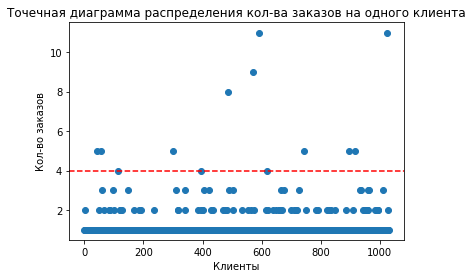

In [30]:
# Построим точечную диаграмму распределения количества заказов
x_values = pd.Series(range(0,len(orders_by_visitors)))
plt.scatter(x_values, orders_by_visitors['orders'])
plt.axhline(y = 4, color = 'red', linestyle = '--')
plt.title('Точечная диаграмма распределения кол-ва заказов на одного клиента')
plt.xlabel('Клиенты')
plt.ylabel('Кол-во заказов')
plt.show()

Больше двух заказов на одного клиента встречается редко, больше 4-х можно считать выбросами.

### 2.7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [31]:
np.percentile(orders_by_visitors['orders'], [95, 99])

array([2., 4.])

Таким образом, у нас не более 5% заказов в кол-ве 2-х штук и не более 1% больше 4-х штук.

Можно выбрать 4 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

### 2.8. Построение точечного графика стоимостей заказов

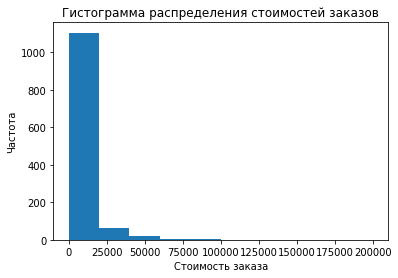

In [32]:
# Сначала посмотрим на гистограмму распределения стоимостей заказов
plt.hist(orders['revenue'], range = [0, 200000])
plt.title('Гистограмма распределения стоимостей заказов')
plt.xlabel('Стоимость заказа')
plt.ylabel('Частота')
plt.show()

Основная масса заказов до 50000, несколько заказов больше 75000.

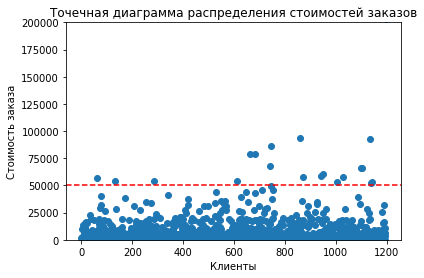

In [33]:
# Построим точечный график распределения стоимости заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylim(0, 200000)
plt.axhline(y = 50000, color = 'red', linestyle = '--')
plt.title('Точечная диаграмма распределения стоимостей заказов')
plt.xlabel('Клиенты')
plt.ylabel('Стоимость заказа')
plt.show()

На точечном графике также видно что основная масса заказов лежит в пределах 50000. Далее можно определить 95-й и 99-й процентили.

### 2.9. Посчитаем 95-й и 99-й перцентили стоимости заказов

In [34]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Таким образом, у нас не более 5% заказов дороже 28000 и не более 1% дороже 58233.

Можно выбрать стоимость одного заказа в 28000 за нижнюю границу стоимости заказа, и отсеять аномальных пользователей по ней.

### 2.10. Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным

In [35]:
# Посчитаем кол-во посетителей в день по группам
visitors_daily_A = visitors[visitors['group'] == 'A'][['date','visitors']]
visitors_daily_A.columns = ['date', 'visitors_per_date_A']

visitors_daily_B = visitors[visitors['group'] == 'B'][['date','visitors']]
visitors_daily_B.columns = ['date', 'visitors_per_date_B']

In [36]:
# Посчитаем кумулятивное кол-во посетителей в день по группам
visitors_cummulative_A = visitors_daily_A.apply(lambda x: visitors_daily_A[visitors_daily_A['date'] <= x['date']]\
                                                .agg({'date' : 'max', 'visitors_per_date_A' : 'sum'}), axis = 1)
visitors_cummulative_A.columns = ['date', 'visitors_cummulative_A']

visitors_cummulative_B = visitors_daily_B.apply(lambda x: visitors_daily_B[visitors_daily_B['date'] <= x['date']]\
                                                .agg({'date' : 'max', 'visitors_per_date_B' : 'sum'}), axis = 1)
visitors_cummulative_B.columns = ['date', 'visitors_cummulative_B']

In [37]:
# Посчитаем кол-во заказов в день по группам
orders_daily_A = orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
orders_daily_A.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_daily_B = orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transaction_id' : pd.Series.nunique, 'revenue' : 'sum'})
orders_daily_B.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

In [38]:
# Посчитаем кумулятивное кол-во заказов в день по группам
orders_cummulative_A = orders_daily_A.apply(lambda x: orders_daily_A[orders_daily_A['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'orders_per_date_A' : 'sum',
                'revenue_per_date_A' : 'sum'}), axis = 1)\
.sort_values(by = ['date'])
orders_cummulative_A.columns = ['date', 'orders_cummulative_A', 'revenue_cummulative_A']

orders_cummulative_B = orders_daily_B.apply(lambda x: orders_daily_B[orders_daily_B['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'orders_per_date_B' : 'sum',
                'revenue_per_date_B' : 'sum'}), axis = 1)\
.sort_values(by = ['date'])
orders_cummulative_B.columns = ['date', 'orders_cummulative_B', 'revenue_cummulative_B']

In [39]:
# Соберем все данные в одну таблицу
merged_orders = orders_daily_A.merge(orders_daily_B, left_on = 'date', right_on = 'date', how = 'left')\
.merge(orders_cummulative_A, left_on = 'date', right_on = 'date', how = 'left')\
.merge(orders_cummulative_B, left_on = 'date', right_on = 'date', how = 'left')\
.merge(visitors_daily_A, left_on = 'date', right_on = 'date', how = 'left')\
.merge(visitors_daily_B, left_on = 'date', right_on = 'date', how = 'left')\
.merge(visitors_cummulative_A, left_on = 'date', right_on = 'date', how = 'left')\
.merge(visitors_cummulative_B, left_on = 'date', right_on = 'date', how = 'left')
merged_orders.head()

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [40]:
# Посчитаем кол-во заказов для пользователей, которые заказывали хотя бы 1 раз по группам A и B
orders_by_users_A = orders[orders['group'] == 'A'].groupby('visitor_id', as_index = False)\
.agg({'transaction_id' : pd.Series.nunique})
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = orders[orders['group'] == 'B'].groupby('visitor_id', as_index = False)\
.agg({'transaction_id' : pd.Series.nunique})
orders_by_users_B.columns = ['user_id', 'orders']

In [41]:
# Объявим переменные sample_A и sample_B, в которых пользователям из разных групп будет соответствовать количество заказов.
# Тем, кто ничего не заказал, будут соответствовать нули.

sample_A = pd.concat(
    [orders_by_users_A['orders'], 
     pd.Series(0, index = np.arange(merged_orders['visitors_per_date_A'].sum()
                                    - len(orders_by_users_A['orders'])), name = 'orders')],axis = 0)

sample_B = pd.concat(
    [orders_by_users_B['orders'], 
     pd.Series(0, index = np.arange(merged_orders['visitors_per_date_B'].sum()
                                    - len(orders_by_users_B['orders'])), name = 'orders')],axis = 0)

   
- Нулевая гипотеза "H0: Конверсия по группе А равна конверсии по группе В"
- Альтернативная гипотеза "H1 (альтернативная): Конверсия по группе А не равна конверсии по группе В"</span>

In [42]:
# Проверим выборки критерием Манна-Уитни и посчитаем относительный прирост конверсии группы B
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sample_A, sample_B)[1]))

print("Относительный прирост конверсии группы B: {0:.3f}".format(sample_B.mean()/sample_A.mean() - 1))

p-value: 0.008
Относительный прирост конверсии группы B: 0.138


P-value < 0.05, следовательно нулевую гипотезу о том, что статистически значимых различий в конверсии между группами A и B нет - отвергаем.

Относительный прирост конверсии группы B по "сырым" данным составляет 13,8%.

### 2.11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

   
- Нулевая гипотеза "H0: Средний чек в группе А равен среднему чеку в группе В"
- Альтернативная гипотеза "H1: Средний чек в группе А не равен среднему чеку в группе В"</span>

In [43]:
# Проверим выборки критерием Манна-Уитни и посчитаем относительную разницу среднего чека группы B
print("p-value: {0:.3f}".format(stats.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], 
                                          orders[orders['group'] == 'B']['revenue'])[1]))

print("Относительная разница: {0:.3f}".format(orders[orders['group'] == 'B']['revenue']\
                                                            .mean()/orders[orders['group'] == 'A']['revenue'].mean() - 1))

p-value: 0.365
Относительная разница: 0.259


P-value > 0.05, Значит нулевую гипотезу о равенстве среднего чека в группах не удалось опровергнуть.

Средний чек группы B выше среднего чека группы A на 25,9%.

### 2.12. Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным

In [44]:
# Отсортируем пользователей с числом заказов больше 2-х
users_with_many_orders = pd.concat(
    [orders_by_users_A[orders_by_users_A['orders'] > 2]['user_id'], 
     orders_by_users_B[orders_by_users_B['orders'] > 2]['user_id']], 
    axis = 0)
users_with_many_orders.head()

18      199603092
23      237748145
68      611059232
146    1230306981
189    1614305549
Name: user_id, dtype: int64

In [45]:
# Отсортируем пользователей с суммой заказа больше 28000
users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']
users_with_expensive_orders.head()

60     4256040402
73     2947100995
77      787824685
78     3288820196
131    2254586615
Name: visitor_id, dtype: int64

In [46]:
# Соединим данные в одну таблицу
abnormal_users = pd.concat(
    [users_with_many_orders,
     users_with_expensive_orders],
    axis = 0).drop_duplicates().sort_values()
abnormal_users

1099     148427295
18       199603092
928      204675465
23       237748145
37       249864742
           ...    
723     4009017467
627     4120364173
743     4133034833
499     4256040402
662     4266935830
Length: 74, dtype: int64

Таким образом, получилось 74 аномальных пользователя

Узнаем, как они повлияли на результаты теста.

In [47]:
# Получим выборки по отфильтрованным данным групп А и B
sample_filtered_A = pd.concat(
    [orders_by_users_A[np.logical_not(orders_by_users_A['user_id'].isin(abnormal_users))]['orders'],
     pd.Series(0, index = np.arange(merged_orders['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])),
               name = 'orders')],
    axis = 0)

sample_filtered_B = pd.concat(
    [orders_by_users_B[np.logical_not(orders_by_users_B['user_id'].isin(abnormal_users))]['orders'],
     pd.Series(0, index = np.arange(merged_orders['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])),
               name = 'orders')],
    axis = 0)

- Нулевая гипотеза "H0: Конверсия по "очищенным" данным в группе А равна конверсии в группе В"
- Альтернативная гипотеза "H1: Конверсия по "очищенным" данным в группе А не равна конверсии в группе В"</span>

In [48]:
# Проверим выборки критерием Манна-Уитни и посчитаем относительный прирост конверсии группы B по "очищенным" данным
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sample_filtered_A, sample_filtered_B)[1]))
print("Относительный прирост конверсии группы B: {0:.3f}".format(sample_filtered_B.mean()/sample_filtered_A.mean() - 1))

p-value: 0.007
Относительный прирост конверсии группы B: 0.173


P-value < 0.05, также как и у "сырых" данных, значит все-таки статистически значимые различия в конверсии между группами A и B есть. Нулевая гипотеза не подтвердилась.

Относительный прирост конверсии группы B по "очищенным" данным составляет 17,3%.

Таким образом, "очистка" данных увеличила относительный прирост конверсии группы B на 3,5%.

### 2.13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным


- Нулевая гипотеза "H0: Средний чек по "очищенным" данным в группе А равен среднему чеку в группе В"
- Альтернативная гипотеза "H1: Средний чек по "очищенным" данным в группе А не равен среднему чеку в группе В"</span>

In [49]:
# Проверим статистическую значимость критерием Манна-Уитни по "очищенным" данным
print("p-value: {0:.3f}".format(
    stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A',
                                             np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'],
                       orders[np.logical_and(orders['group'] == 'B',
                                             np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'])[1]))

p-value: 0.369


In [50]:
# Посчитаем относительную разницу среднего чека группы B по "очищенным" данным
print("Относительная разница: {0:.3f}".format(
    orders[np.logical_and(orders['group'] == 'B', 
                          np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean()/
    orders[np.logical_and(orders['group'] == 'A',
                          np.logical_not(orders['visitor_id'].isin(abnormal_users)))]['revenue'].mean() - 1))

Относительная разница: -0.020


"Очищенные" данные дают почти аналогичный показатель p-value (нулевую гипотезу о равенстве среднего чека в группах не удалось опровергнуть), а вот относительная разница среднего чека снизилась почти на 30% и стала отрицательной: -2%.

После "очистки" данных от 74 аномальных пользователей:
    
- Относительный прирост конверсии группы B составил 17,3%, "очистка" данных увеличила относительный прирост конверсии группы B на 3,5%.
- Относительная разница среднего чека снизилась почти на 30% и стала отрицательной: -2%.

Не подверждена гипотеза о равенстве конверсий групп А и В, а вот гипотеза о равенстве средних чеков групп А и В подтверждена, как на "сырых", так и на "очищенных" данных.

### 2.14. Выбор варианта решения по результатам A/B теста

Я бы порекомендовал <b>остановить тест,признать его успешным - зафиксировать "победу" группы B</b>:

- Есть статистически значимое различие по конверсии между группами как по сырым, так и по "очищенным" данным.
- Нет статистически значимого различия по среднему чеку между группами как по сырым, так и по "очищенным" данным.
- По графику различия конверсии между группами видно, что результаты группы B лучше группы A: установились выше отметки в 10% и имеют тенденцию к росту. После фильтрации данных и удаления аномальных пользователей относительная разница конверсии группы B увеличилась.
- График различия среднего чека сильно колеблется, данные сильно разнятся по "сырым" и по "очищенным" данным, сделать из этого графика определённые выводы нельзя.

<b>Учитывая вышесказанное, по результатам теста можно сделать вывод, что конверсия группы В лучше, средний чек не изменился. Исходя из этого, вариант сайта B более предпочтителен для роста выручки.</b>



<b>Выводы по приоритезации гипотез по увеличению выручки интернет-магазина</b>

При использовании фреймворка <b>ICE</b> наиболее приоритетными гипотезами по увеличению выручки определены:
- "Запустить акцию, дающую на товар в день..."(8)
- "Добавить два новых канала привлечения трафика,..."(0)
- "Добавить форму подписки на все основные страницы..."(7)

После применения фреймворка <b>RICE</b> вместо ICE на первые места вышли две гипотезы:
- "Добавить форму подписки на все основные страницы"(7)
- "Добавить блоки рекомендаций товаров на сайт интернет-магазина"(2)
Это произошло потому что в этом фреймворке был добавлен показатель охват (reach) - скольких пользователей затронет данное изменение, и этот параметр был выше у данных гипотез, а также у гипотезы 3 - "Изменить структуру категорий, что увеличит конверсию". У этой гипотезы, однако, достаточно высокий показатель стоимости проверки гипотезы (efforts), что возможно связано с серьезной переработкой сайта магазина.
    
    В связи с вышесказанным, моя рекомендация для увеличения конверсии и выручки нужно добавить форму подписки на все основные страницы, добавить блоки рекомендаций товаров на сайт.
    Кроме того, также рассмотреть возможность запуска акции, дающую скидку на товар в день регистрации на сайте и подумать над расширением каналов привлечения трафика.
    После внедрения изменений продолжить периодический мониторинг рассмотренных метрик, для оценки эффекта.